In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transforms3d as tf3d
import matplotlib


In [2]:
mass=369 #batterie
mass+=1640-114 #corps-carton
mass/=1e3
Area=np.pi*(11.0e-02)**2
r0=11e-02
rho0=1.204
kv_motor=800.0
pwmmin=1075.0
pwmmax=1950.0
U_batt=16.8
AN=6*Area
b10=14.44

In [3]:
# %%   ####### IMPORT DATA 
print("LOADING DATA...")


log_path="./logs/copter/vol12/log_real_processed.csv"

raw_data=pd.read_csv(log_path)

print("PROCESSING DATA...")


prep_data=raw_data.drop(columns=[i for i in raw_data.keys() if (("forces" in i ) or ('pos' in i) or ("joy" in i)) ])
prep_data=prep_data.drop(columns=[i for i in raw_data.keys() if (("level" in i ) or ('Unnamed' in i) or ("index" in i)) ])
# print(prep_data)

if "vol12" in log_path:
    tmin,tmax=(-1,1e10) 
elif "vol1/" in log_path:
    tmin,tmax=(41,265) 
elif "vol2" in log_path:
    tmin,tmax=(10,140) 
    
prep_data=prep_data[prep_data['t']>tmin]
prep_data=prep_data[prep_data['t']<tmax]
prep_data=prep_data.reset_index()
for i in range(3):
    prep_data['speed_pred[%i]'%(i)]=np.r_[prep_data['speed[%i]'%(i)].values[1:len(prep_data)],0]
    
    

prep_data['dt']=np.r_[prep_data['t'].values[1:]-prep_data['t'].values[:-1],0]
prep_data['t']-=prep_data['t'][0]
prep_data=prep_data.drop(index=[0,len(prep_data)-1])




for i in range(6):
    prep_data['omega_c[%i]'%(i+1)]=(prep_data['PWM_motor[%i]'%(i+1)]-pwmmin)/(pwmmax-pwmmin)*U_batt*kv_motor*2*np.pi/60


LOADING DATA...
PROCESSING DATA...


In [4]:
mes=np.array([prep_data['acc_body_grad[%i]'%(i)] for i in range(3)]).T

In [5]:
mes.shape

(120498, 3)

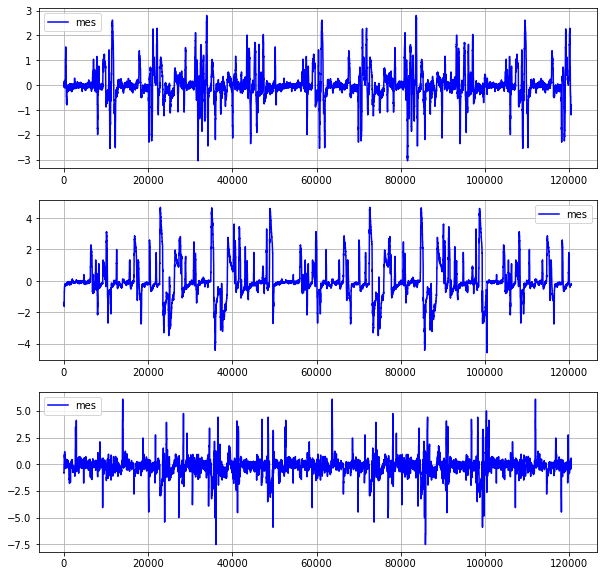

In [6]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.gcf().add_subplot(3,1,i+1)
    plt.plot(mes[:,i],label="mes",color="blue")
    plt.grid(),plt.legend()

In [45]:
from pykalman import KalmanFilter

kf = KalmanFilter(initial_state_mean=mes[0], 
                  initial_state_covariance=0*np.eye(3),
                  transition_matrices=np.eye(3),
                  observation_matrices=np.eye(3),
                  transition_covariance=1e-5*np.eye(3),
                  observation_covariance=5e-2*np.eye(3),
                  n_dim_obs=3)

filt_output_ = kf.filter(mes)

In [46]:
x_est , P_est =  filt_output_

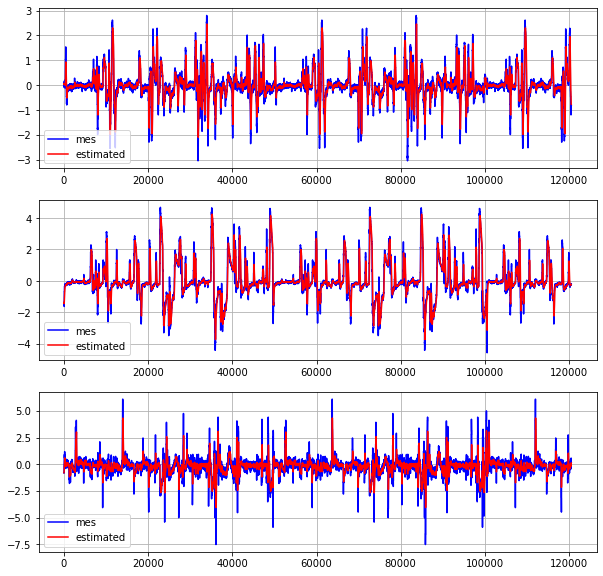

In [47]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.gcf().add_subplot(3,1,i+1)
    plt.plot(mes[:,i],label="mes",color="blue")
    plt.plot(x_est[:,i],label="estimated",color="red")
    plt.grid(),plt.legend()

In [48]:
P_est

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[9.99800040e-06, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.99800040e-06, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.99800040e-06]],

       [[1.99900052e-05, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.99900052e-05, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.99900052e-05]],

       ...,

       [[7.02124459e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.02124459e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.02124459e-04]],

       [[7.02124459e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.02124459e-04, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.02124459e-04]],

       [[7.02124459e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 7.02124459e-04, 0.000000

In [49]:
cov_est_= np.array([[i[0,0],i[1,1],i[2,2]] for i in P_est])
cov_est_.shape

(120498, 3)

In [50]:
cov_est_[-2]

array([0.00070212, 0.00070212, 0.00070212])

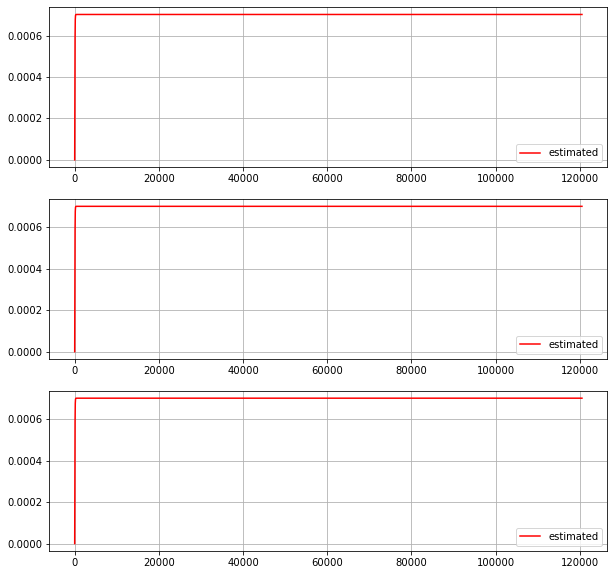

In [51]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.gcf().add_subplot(3,1,i+1)
    plt.plot(cov_est_[:,i],label="estimated",color="red")
    plt.grid(),plt.legend()

(0.0003, 0.00030000000001)

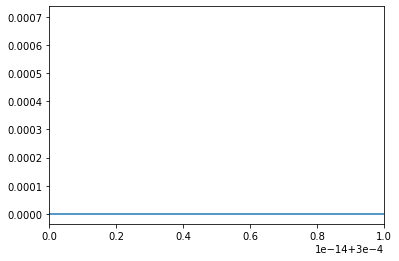

In [52]:
plt.plot(P_est[:,0,0])
plt.gca().set_xlim((3e-4,3.0000000001e-4))